# Federalist Papers Analysis

In [39]:
import pandas as pd
import numpy as np
import os
import nltk, re, pprint
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
%matplotlib inline

In [467]:
#FILEPATH for txt file from Project Gutenberg
authors = '/Users/matthewzhou/Desktop/Test/Federalist/Federalist.txt'

dataset = pd.DataFrame(columns=['meta_author', 'meta_title', 'meta_body'])


f = open(authors)
sample = f.read()
f.close  

#Parse out linebreaks and encodings
sample = sample.replace(u'\ufeff', '')
sample = sample.replace(u'\n', ' ')
sample = sample.lower()
#Eliminate punctuation marks
tokenizer = RegexpTokenizer(r'\w+')
output = tokenizer.tokenize(sample)
output = ' '.join(output)

#Scrape through corpus and isolate author, paper title, and body as features

startindex = []
endindex = []
authors = []
titles = []
for i in range(0, 85):
    search = 'federalist no ' + str(i+1)
    startindex.append(output.find(search))
    endindex.append(startindex[i]+len(search) + 1)
    
federalist = {}
for i in range(84):
    testj = output.find('jay', endindex[i], startindex[i+1])
    testh = output.find('hamilton', endindex[i], startindex[i+1])
    testm = output.find('madison', endindex[i], startindex[i+1])
    testhm = output.find('madison with hamilton', endindex[i], startindex[i+1])
    if testj != -1:
        dp = {
            'meta_author': 'jay',
            'meta_title': output[endindex[i]:testj],
            'meta_body': output[testj+4:startindex[i + 1]]
            }
    elif testhm != -1:
        dp = {
            'meta_author': 'madison with hamilton',
            'meta_title': output[endindex[i]:testhm],
            'meta_body': output[testm+22:startindex[i + 1]]
            }
    elif testh != -1:
        dp = {
            'meta_author': 'hamilton',
            'meta_title': output[endindex[i]:testh],
            'meta_body': output[testh+9:startindex[i + 1]]
            }
    elif testm != -1:
        dp = {
            'meta_author': 'madison',
            'meta_title': output[endindex[i]:testm],
            'meta_body': output[testm+8:startindex[i + 1]]
            }
    dataset = dataset.append(dp, ignore_index=True)
testh = output.find('hamilton', endindex[84])
dp = {
    'meta_author': 'hamilton',
    'meta_title': output[endindex[84]:testh],
    'meta_body': output[testh+9:1124005]
    }
dataset = dataset.append(dp, ignore_index=True)

In [466]:
dataset.head()

,meta_author,meta_title,meta_body
0,hamilton,general introduction for the independent journ...,to the people of the state of new york after a...
1,jay,concerning dangers from foreign force and infl...,to the people of the state of new york when th...
2,jay,the same subject continued concerning dangers ...,to the people of the state of new york it is n...
3,jay,the same subject continued concerning dangers ...,to the people of the state of new york my last...
4,jay,the same subject continued concerning dangers ...,to the people of the state of new york queen a...


In [470]:
# Convert the text into tf_idf values
stop_list = ['the','and','of','to','in','it','which','is','be','that','then','or','his', 'he', 'would','her','they','our','as','will','by','with','you','my','not','this','are','your', 'their', 'for', 'than', 'may', 'an', 'from', 'its', 'have', 'at', 'from', 'if', 'them', 'we', 'on', 'upon', 'an', 'been', 'were', 'us','those', 'who', 'was', 'has', 'she', 'there', 'has', 'can', 'could', 'had', 'but']
vec = TfidfVectorizer(stop_words = stop_list, ngram_range = (1,7))

tf_idf_vec = vec.fit_transform(dataset['meta_body'])

# Convert the tf_idf matrix into a data frame with labels
tf_idf_df = pd.DataFrame(columns=vec.get_feature_names(), data=tf_idf_vec.toarray())

# Combine the original data set with the tf_idf dataframe
cluster_df = dataset.join(tf_idf_df).drop('meta_body', 1)

# These are our final data sets.  y is author, X contains the text data
y_set = cluster_df['meta_author']

X_set = cluster_df

# Naive way to graph a cluster is just reduce the dimensions to 2 with svd

svd = TruncatedSVD(n_components=2)
svd.fit(X_set.drop(['meta_author', 'meta_title'], 1))

svd_plotdata = []
authors = X_set['meta_author'].unique()


for author in authors:
    svd_plotdata.append(svd.transform(X_set.loc[X_set['meta_author'] == author].drop(['meta_author', 'meta_title'], 1)))
    

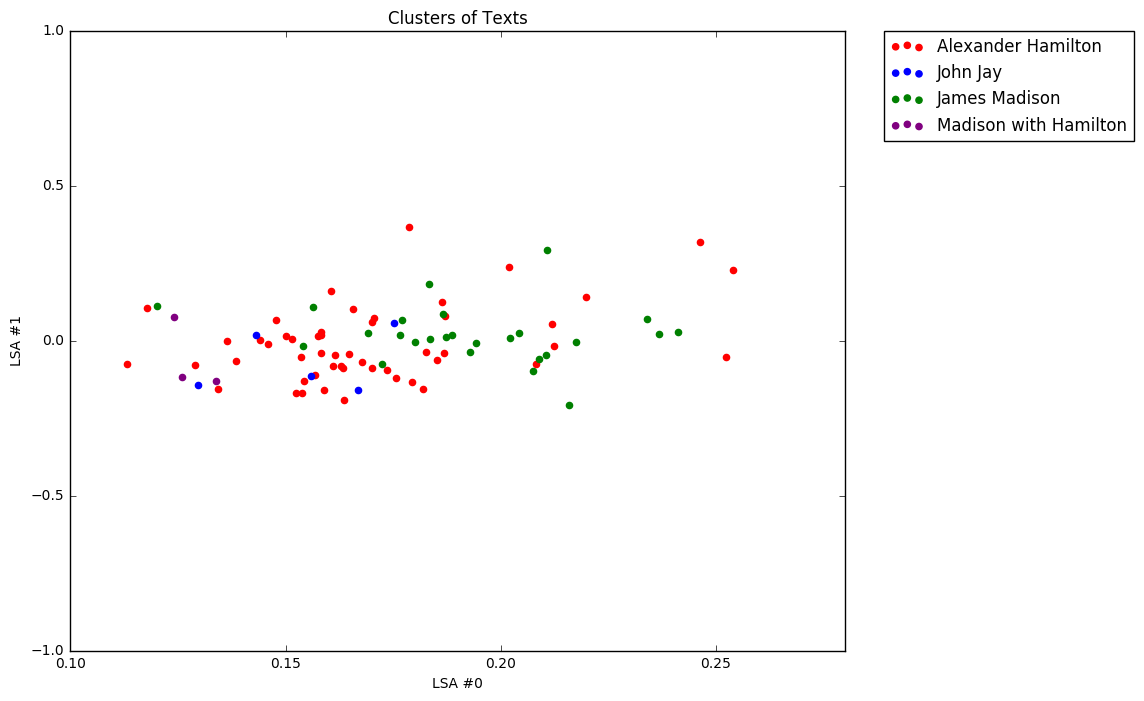

In [471]:
# Graph the results on a 2D plane
plt.figure(figsize=(10,8), dpi=300)
plt.ylabel('LSA #1')
plt.xlabel('LSA #0')
plt.ylim(ymin=-1, ymax=1)
plt.title('Clusters of Texts')

display_color = ['red', 'blue', 'green', 'purple', 'cyan', 'orange', 'yellow']

ci = 0
namelist = ['Alexander Hamilton', 'John Jay', 'James Madison', 'Madison with Hamilton']
for plotdata in svd_plotdata:
    plt.scatter(plotdata[:, 0], plotdata[:,1], color=display_color[ci], label = namelist[ci])
    ci += 1
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

# Note on Visualization

* Red: Alexander Hamilton
* Blue: John Jay
* Green: James Madison

# **Vocabulary Analysis**

In [472]:
vocabulary = vec.vocabulary_
feature_names = vec.get_feature_names() 
print("Number of unique words considered: " + str(len(feature_names)))
feature_names[50:60]

Number of unique words considered: 558669


['13th charles ii chap',
 '13th charles ii chap declared',
 '13th charles ii chap declared king',
 '13th charles ii chap declared king alone',
 '1648',
 '1648 independence',
 '1648 independence formerly',
 '1648 independence formerly finally',
 '1648 independence formerly finally recognized',
 '1648 independence formerly finally recognized concluded']

In [473]:
dense = tf_idf_vec.todense()
paper = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(paper)), paper) if pair[1] > 0]
print("Sample word vectors with td-idf score:")
sorted(phrase_scores, key=lambda t: t[1] * -1)[:5]

Sample word vectors with td-idf score:


[(322158, 0.04585004561633376),
 (33892, 0.039963574506025154),
 (292401, 0.028751377624157047),
 (145944, 0.0283805674985628),
 (204899, 0.0283805674985628)]

In [479]:
count = 0
tfscores = []
ham = []
jay = []
mad = []
for i in dense:
    paper = i.tolist()[0]
    phrase_scores = [pair for pair in zip(range(0, len(paper)), paper) if pair[1] > 0]
    sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
    print("\n Paper " + str(count+1) + "         | " + str(dataset.loc[count].meta_author) + "\n")
    count += 1
    counter = 0
    for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:10]:
        print('{0: <20} {1}'.format(phrase, score))
        if dataset.loc[counter].meta_author == 'hamilton':
            ham.append(phrase)
        elif dataset.loc[counter].meta_author == 'jay':
            jay.append(phrase)
        elif (dataset.loc[counter].meta_author == 'madison') | (dataset.loc[counter].meta_author == 'madison with hamilton'):
            mad.append(phrase)
        if counter == 0:
            tfscores.append(score)
        counter += 1


 Paper 1         | hamilton

new constitution     0.04585004561633376
appearance           0.039963574506025154
men                  0.028751377624157047
efficiency government 0.0283805674985628
good men             0.0283805674985628
right side           0.0283805674985628
utility union        0.0283805674985628
all                  0.02682360552806312
government           0.02682360552806312
constitution         0.026478877476708174

 Paper 2         | jay

people               0.0640800895203587
providence           0.039795408213650296
induced people       0.03640642033213468
recommended          0.03629855920121981
congress             0.034925040582694585
convention           0.03437644473930884
america              0.03128612261931017
one                  0.027860908487112472
union                0.026876906984942706
america depended     0.02653027214243353

 Paper 3         | jay

national government  0.0727700034472731
causes war           0.05995713237835176
just causes     

In [475]:
print("Most common words for Madison")
Counter(mad).most_common()[:10]

Most common words for Madison


[('government', 12),
 ('states', 12),
 ('state', 9),
 ('people', 6),
 ('other', 4),
 ('representatives', 4),
 ('governments', 3),
 ('all', 3),
 ('knowledge', 3),
 ('powers', 3)]

In [476]:
print("Most common words for Hamilton")
Counter(ham).most_common()[:10]

Most common words for Hamilton


[('government', 8),
 ('president', 8),
 ('states', 8),
 ('power', 7),
 ('executive', 6),
 ('senate', 6),
 ('state', 6),
 ('national', 6),
 ('union', 5),
 ('court', 5)]

In [477]:
print("Most common words for Jay")
Counter(jay).most_common()[:10]

Most common words for Jay


[('government', 3),
 ('nations', 2),
 ('people', 2),
 ('congress', 1),
 ('navigation fleet let', 1),
 ('national government', 1),
 ('efficiency government', 1),
 ('senate', 1),
 ('navigation', 1),
 ('militia obeyed', 1)]